In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../Data/advertising.csv")
print(df.head())

      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3   12.0
3  151.5   41.3       58.5   16.5
4  180.8   10.8       58.4   17.9


# Handling Missing Values

In [2]:
df = df.fillna(0)

# Feature Selection and Target Variable

In [3]:
x = df[['TV', 'Radio', 'Newspaper']].values
y = df['Sales'].values

# Min-Max Scaling

In [4]:
x_min = x.min(axis=0)
x_max = x.max(axis=0)
x_minmax = (x - x_min) / (x_max - x_min)

In [5]:
x_minmax = np.c_[np.ones(x_minmax.shape[0]), x_minmax]

# Standard Scaling

In [6]:
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)
x_standard = (x - x_mean) / x_std

In [7]:
x_standard = np.c_[np.ones(x_standard.shape[0]), x_standard]

# Outlier Removal using Z-Score
We use the z-score method to remove outliers from our dataset:
- Calculate z-scores for each feature
- Remove data points where any feature has |z-score| > 3
- This assumes the data follows a normal distribution
- Points with z-score > 3 are considered outliers as they lie beyond 3 standard deviations

In [8]:
z_scores = np.abs((x - x_mean) / x_std)
print(f"Z-scores shape: {z_scores.shape}")

non_outliers_mask = (z_scores < 3).all(axis=1)
print(f"Number of outliers removed: {np.sum(~non_outliers_mask)}")

x_cleaned_minmax = x_minmax[non_outliers_mask]
x_cleaned_standard = x_standard[non_outliers_mask]
y_cleaned = y[non_outliers_mask]
print(f"Cleaned x shape: {x_cleaned_minmax.shape}")
print(f"Cleaned y shape: {y_cleaned.shape}")

Z-scores shape: (200, 3)
Number of outliers removed: 2
Cleaned x shape: (198, 4)
Cleaned y shape: (198,)


# Model Training and Comparison
We use batch gradient descent to train two linear regression models:
1. One with Min-Max scaled features
2. One with Standardized features

The comparison of Mean Squared Error (MSE) between the two models will help us understand which scaling technique works better for this specific dataset.

In [11]:
def batch_gradient_descent(x, y, lr=0.1, epochs=1000):
    weights = np.zeros(x.shape[1])
    weights_history = []
    loss_history = []
    
    for epoch in range(epochs):
        predictions = x @ weights
        errors = predictions - y
        mse = np.mean(errors ** 2)
        gradient = (2 / len(y)) * x.T @ errors
        weights -= lr * gradient
        
        # Store weights and loss history
        weights_history.append(weights.copy())
        loss_history.append(mse)
        
    return weights, np.array(weights_history), np.array(loss_history)

# Train both models and get histories
weights1, weights_history1, loss_history1 = batch_gradient_descent(x_cleaned_minmax, y_cleaned)
weights2, weights_history2, loss_history2 = batch_gradient_descent(x_cleaned_standard, y_cleaned)

# Predict and calculate final MSE
y_pred_minmax = x_cleaned_minmax @ weights1
y_pred_standard = x_cleaned_standard @ weights2
mse_minmax = np.mean((y_cleaned - y_pred_minmax) ** 2)
mse_standard = np.mean((y_cleaned - y_pred_standard) ** 2)

# Output final results
print("Final Weights after Min-Max Scaling:", weights1)
print("Final Weights after Standard Scaling:", weights2)
print(f"Final MSE after Min-Max Scaling: {mse_minmax:.7f}")
print(f"Final MSE after Standard Scaling: {mse_standard:.7f}")

Final Weights after Min-Max Scaling: [ 4.63742403 16.12884886  5.30067876  0.10687065]
Final Weights after Standard Scaling: [15.13422588  4.67115626  1.58338952  0.01875092]
Final MSE after Min-Max Scaling: 2.7289607
Final MSE after Standard Scaling: 2.7289585


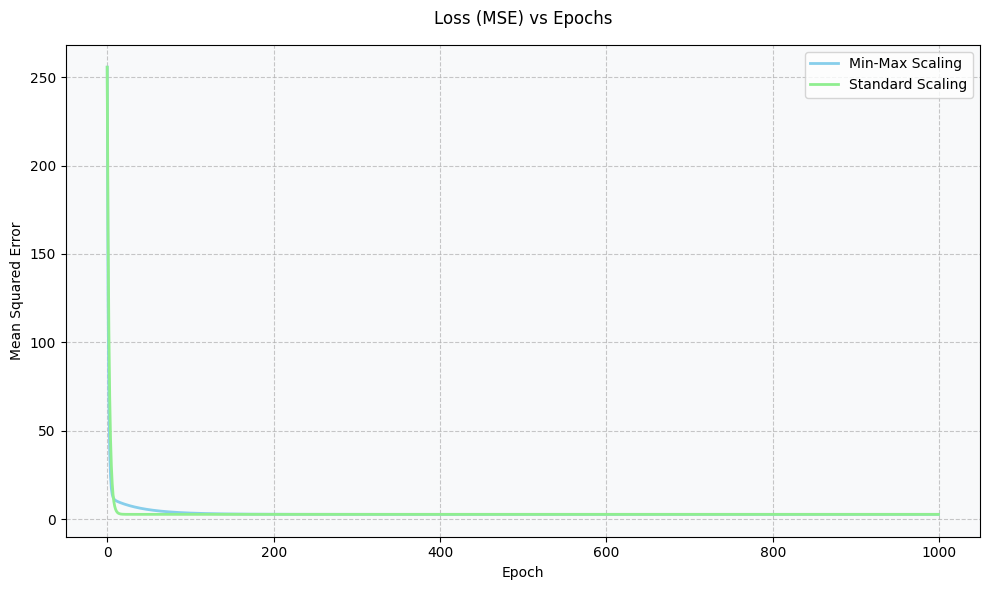

In [14]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(10, 6))

# Plot Loss History
plt.plot(loss_history1, label='Min-Max Scaling', color='skyblue', linewidth=2)
plt.plot(loss_history2, label='Standard Scaling', color='lightgreen', linewidth=2)

# Customize the plot
plt.title('Loss (MSE) vs Epochs', fontsize=12, pad=15)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Mean Squared Error', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a light gray background grid for better readability
plt.gca().set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()